## Env Creative

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio.v2

## Function to add Gaussian noise to the image

In [2]:
def add_noise(img, noise_level):
    noise = np.random.normal(0, noise_level, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

## Define the DIP model

In [3]:
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## Load target image

In [4]:
img_path = '/kaggle/input/lenna-test-image/Lenna_(test_image).png'
target_img = imageio.imread(img_path)

if target_img.dtype == np.uint8:
    target_img = target_img / 255.0

/tmp/ipykernel_24/1330099834.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  target_img = imageio.imread(img_path)


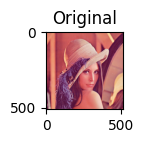

In [5]:
# check the picture load correctly
plt.figure(figsize=(3, 1))
plt.title("Original")
plt.imshow(np.clip(target_img, 0, 1))
plt.show()

## Define noise levels and schedule

In [6]:
schedules = {
    "gradual": [0.1, 0.05, 0.025],
    "fast": [0.1, 0.01, 0.001],
    "slow": [0.1, 0.075, 0.05]
}

## Define epochs per stage for each schedule

In [7]:
epochs_per_stage = [500, 1000, 1500]

## Prepare for Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
def initialize_model():
    model = DIPModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    return model, optimizer

In [10]:
def train_schedule(schedule_name, noise_levels, epochs_per_stage):
    psnr_results = []
    ssim_results = []

    noisy_images = [add_noise(target_img, noise_level) for noise_level in noise_levels]
    noisy_images_torch = [torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0).float().to(device) for img in noisy_images]
    target_img_torch = torch.tensor(target_img.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

    model, optimizer = initialize_model()
    criterion = nn.MSELoss()

    patience = 50
    best_psnr = 0
    best_model = None
    eval_interval = 100  # Set evaluation interval to 100 epochs

    for stage, (noisy_img_torch, num_epochs) in enumerate(zip(noisy_images_torch, epochs_per_stage)):
        print(f"Training on schedule {schedule_name}, stage {stage + 1} with noise level {noise_levels[stage]}")
        no_improvement_count = 0

        for epoch in tqdm(range(num_epochs)):
            model.train()
            optimizer.zero_grad()
            output = model(noisy_img_torch)
            loss = criterion(output, target_img_torch)
            loss.backward()
            optimizer.step()

            if epoch % eval_interval == 0 or epoch == num_epochs - 1:
                model.eval()
                with torch.no_grad():
                    output_img = output.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
                    output_img = np.clip(output_img, 0, 1)
                    current_psnr = psnr(target_img, output_img, data_range=1.0)
                    current_ssim = ssim(target_img, output_img, data_range=1.0, channel_axis=-1)

                    if current_psnr > best_psnr:
                        best_psnr = current_psnr
                        best_model = model.state_dict()
                        no_improvement_count = 0
                    else:
                        no_improvement_count += 1

                    if no_improvement_count >= patience:
                        print(f"Early stopping at epoch {epoch} in schedule {schedule_name}, stage {stage + 1}")
                        break

        model.load_state_dict(best_model)
        psnr_results.append(best_psnr)
        ssim_results.append(current_ssim)

    return psnr_results, ssim_results

## Training

In [11]:
results = {}
for schedule_name, noise_levels in schedules.items():
    psnr_results, ssim_results = train_schedule(schedule_name, noise_levels, epochs_per_stage)
    results[schedule_name] = {
        "psnr": psnr_results,
        "ssim": ssim_results
    }

Training on schedule gradual, stage 1 with noise level 0.1


100%|██████████| 500/500 [00:14<00:00, 33.93it/s]


Training on schedule gradual, stage 2 with noise level 0.05


100%|██████████| 1000/1000 [00:27<00:00, 36.43it/s]


Training on schedule gradual, stage 3 with noise level 0.025


100%|██████████| 1500/1500 [00:42<00:00, 35.17it/s]


Training on schedule fast, stage 1 with noise level 0.1


100%|██████████| 500/500 [00:14<00:00, 35.35it/s]


Training on schedule fast, stage 2 with noise level 0.01


100%|██████████| 1000/1000 [00:27<00:00, 35.78it/s]


Training on schedule fast, stage 3 with noise level 0.001


100%|██████████| 1500/1500 [00:42<00:00, 35.56it/s]


Training on schedule slow, stage 1 with noise level 0.1


100%|██████████| 500/500 [00:14<00:00, 35.12it/s]


Training on schedule slow, stage 2 with noise level 0.075


100%|██████████| 1000/1000 [00:28<00:00, 35.27it/s]


Training on schedule slow, stage 3 with noise level 0.05


100%|██████████| 1500/1500 [00:42<00:00, 35.34it/s]


## Visulize the result

In [12]:
for schedule_name, metrics in results.items():
    psnr_formatted = [f'{val:.4f}' for val in metrics["psnr"]]
    ssim_formatted = [f'{val:.4f}' for val in metrics["ssim"]]
    print(f'PSNR results for {schedule_name}: {psnr_formatted}')
    print(f'SSIM results for {schedule_name}: {ssim_formatted}')

PSNR results for gradual: ['30.4998', '33.6007', '36.4057']
SSIM results for gradual: ['0.7792', '0.8621', '0.9187']
PSNR results for fast: ['30.1121', '37.8815', '42.0065']
SSIM results for fast: ['0.7676', '0.9530', '0.9851']
PSNR results for slow: ['30.1359', '32.0934', '33.8823']
SSIM results for slow: ['0.7689', '0.8262', '0.8686']


Average PSNR for gradual: 33.5021
Average PSNR for fast: 36.6667
Average PSNR for slow: 32.0372


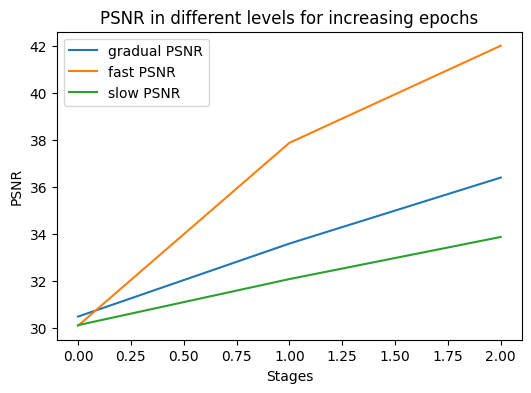

In [13]:
plt.figure(figsize=(6, 4))
for schedule_name, metrics in results.items():
    plt.plot(metrics["psnr"], label=f'{schedule_name} PSNR')
    avg_psnr = np.mean(metrics["psnr"])
    print(f'Average PSNR for {schedule_name}: {avg_psnr:.4f}')
plt.xlabel('Stages')
plt.ylabel('PSNR')
plt.legend()
plt.title('PSNR in different levels for increasing epochs')
plt.show()

Average SSIM for gradual: 0.8533
Average SSIM for fast: 0.9019
Average SSIM for slow: 0.8212


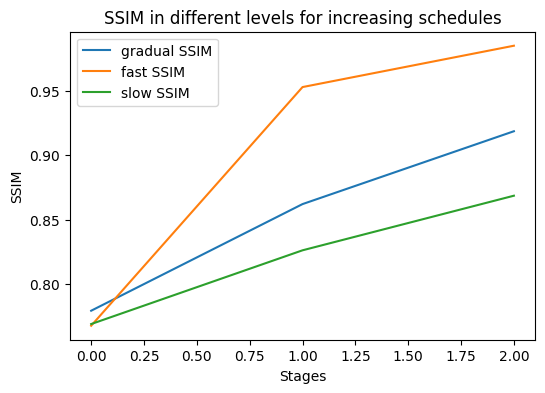

In [14]:
plt.figure(figsize=(6, 4))
for schedule_name, metrics in results.items():
    plt.plot(metrics["ssim"], label=f'{schedule_name} SSIM')
    avg_ssim = np.mean(metrics["ssim"])
    print(f'Average SSIM for {schedule_name}: {avg_ssim:.4f}')
plt.xlabel('Stages')
plt.ylabel('SSIM')
plt.legend()
plt.title('SSIM in different levels for increasing schedules')
plt.show()